In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets as ds
from sklearn.metrics import classification_report, confusion_matrix
from pycaret.classification import *
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')
df = ds.fetch_openml(data_id=151,as_frame=True, return_X_y=True)

(

    pd.concat(df, axis=1)

    .assign(target=lambda x: (x['class']=='UP')*1)

)

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class,target
0,0.0000,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP,1
1,0.0000,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP,1
2,0.0000,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP,1
3,0.0000,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP,1
4,0.0000,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,0
...,...,...,...,...,...,...,...,...,...,...
45307,0.9158,7,0.914894,0.044224,0.340672,0.003033,0.255049,0.405263,DOWN,0
45308,0.9158,7,0.936170,0.044884,0.355549,0.003072,0.241326,0.420614,DOWN,0
45309,0.9158,7,0.957447,0.043593,0.340970,0.002983,0.247799,0.362281,DOWN,0
45310,0.9158,7,0.978723,0.066651,0.329366,0.004630,0.345417,0.206579,UP,1


Electricity is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends).

The data was normalized by A. Bifet.


    Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
    Day: day of the week (1-7)
    Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
    NSWprice: New South Wales electricity price, normalized between 0 and 1
    NSWdemand: New South Wales electricity demand, normalized between 0 and 1
    VICprice: Victoria electricity price, normalized between 0 and 1
    VICdemand: Victoria electricity demand, normalized between 0 and 1
    transfer: scheduled electricity transfer between both states, normalized between 0 and 1


# Exploratory Data Analysis

Firts step is to understand the data and have a better picture of the problem.

In [2]:
idx = pd.date_range(start='1996-05-07', end='1998-12-7', freq='0.5H')

In [3]:
idx = idx[:-1]

In [4]:
df_features = df[0]

In [5]:
df_features.set_index(idx, inplace=True)

In [6]:
df_features = df_features[['nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']]

In [7]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45312 entries, 1996-05-07 00:00:00 to 1998-12-06 23:30:00
Freq: 30T
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   nswprice   45312 non-null  float64
 1   nswdemand  45312 non-null  float64
 2   vicprice   45312 non-null  float64
 3   vicdemand  45312 non-null  float64
 4   transfer   45312 non-null  float64
dtypes: float64(5)
memory usage: 2.1 MB


<AxesSubplot:>

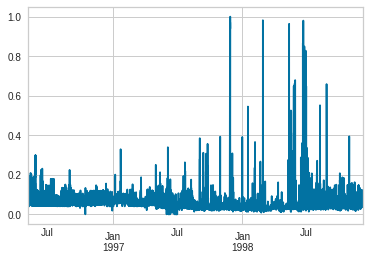

In [8]:
df_features.nswprice.plot()

<AxesSubplot:>

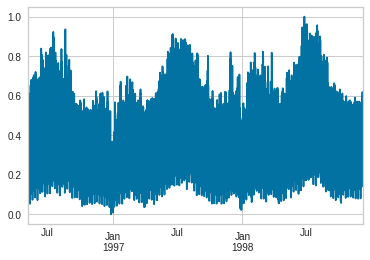

In [9]:
df_features.nswdemand.plot()


<AxesSubplot:>

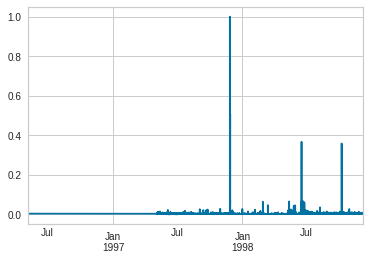

In [10]:
df_features.vicprice.plot()


<AxesSubplot:>

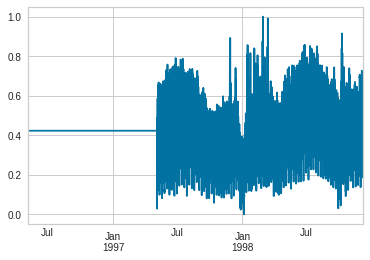

In [11]:
df_features.vicdemand.plot()

In [12]:
df_features['diff'] = df_features['vicdemand'].diff()
df_filtered = df_features[df_features['diff'] != 0]
df_filtered.head()

,nswprice,nswdemand,vicprice,vicdemand,transfer,diff
1996-05-07 00:00:00,0.056443,0.439155,0.003467,0.422915,0.414912,NaN
1997-05-05 00:00:00,0.046325,0.298274,0.003232,0.296737,0.500526,-0.126178
1997-05-05 00:30:00,0.045485,0.253794,0.003145,0.268255,0.500526,-0.028482
1997-05-05 01:00:00,0.047316,0.231032,0.002910,0.306577,0.500526,0.038322
1997-05-05 01:30:00,0.036658,0.183130,0.002956,0.271621,0.500526,-0.034956


In [13]:
df_features.drop(columns='diff', inplace=True)

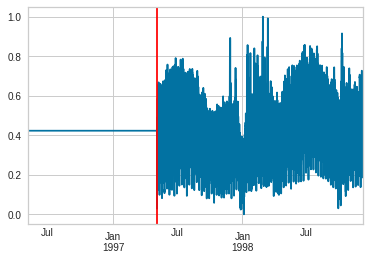

In [14]:
df_features.vicdemand.plot()
plt.axvline('1997-05-05 00:00:00', color='red')

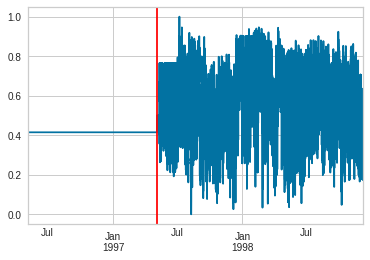

In [15]:
df_features.transfer.plot()
plt.axvline('1997-05-05 00:00:00', color='red')

Clearly the data has a change of concept after the date 1998-11-17 15:00:00 so to avoid a poor modeling, we will only use the data from this instace forward. 

In [16]:
df_features = df_features.loc[df_features.index > '1997-05-05 00:00:00'].copy()

<AxesSubplot:>

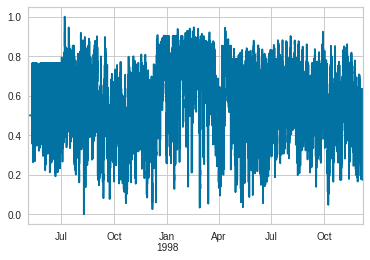

In [17]:
df_features.transfer.plot()

<AxesSubplot:>

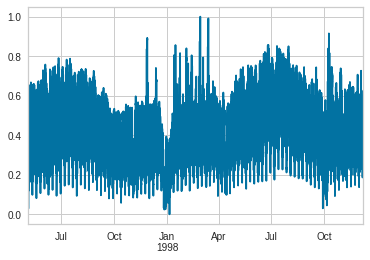

In [18]:
df_features.vicdemand.plot()


<AxesSubplot:>

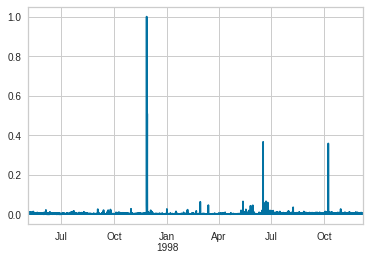

In [19]:
df_features.vicprice.plot()

<AxesSubplot:>

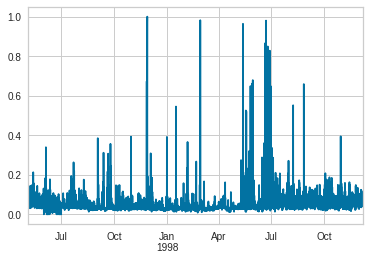

In [20]:
df_features.nswprice.plot()

<AxesSubplot:>

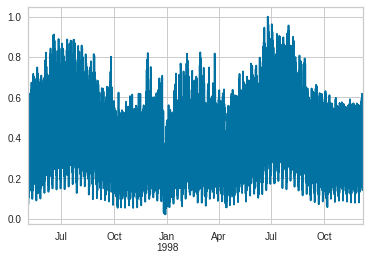

In [21]:
df_features.nswdemand.plot()


In [22]:
df_features

,nswprice,nswdemand,vicprice,vicdemand,transfer
1997-05-05 00:30:00,0.045485,0.253794,0.003145,0.268255,0.500526
1997-05-05 01:00:00,0.047316,0.231032,0.002910,0.306577,0.500526
1997-05-05 01:30:00,0.036658,0.183130,0.002956,0.271621,0.500526
1997-05-05 02:00:00,0.041882,0.148319,0.002659,0.219834,0.500526
1997-05-05 02:30:00,0.033776,0.119905,0.002418,0.167530,0.500526
...,...,...,...,...,...
1998-12-06 21:30:00,0.044224,0.340672,0.003033,0.255049,0.405263
1998-12-06 22:00:00,0.044884,0.355549,0.003072,0.241326,0.420614
1998-12-06 22:30:00,0.043593,0.340970,0.002983,0.247799,0.362281
1998-12-06 23:00:00,0.066651,0.329366,0.004630,0.345417,0.206579


In [23]:
df_target=df[1]

In [24]:
df_target = pd.DataFrame(df_target)

In [25]:
df_target.head()

,class
0,UP
1,UP
2,UP
3,UP
4,DOWN


In [26]:
df_features.tail()

,nswprice,nswdemand,vicprice,vicdemand,transfer
1998-12-06 21:30:00,0.044224,0.340672,0.003033,0.255049,0.405263
1998-12-06 22:00:00,0.044884,0.355549,0.003072,0.241326,0.420614
1998-12-06 22:30:00,0.043593,0.340970,0.002983,0.247799,0.362281
1998-12-06 23:00:00,0.066651,0.329366,0.004630,0.345417,0.206579
1998-12-06 23:30:00,0.050679,0.288753,0.003542,0.355256,0.231140


In [27]:
df_target.set_index(idx, inplace=True)

In [28]:
df_target = df_target.loc[df_target.index > '1997-05-05 00:00:00'].copy()

In [29]:
df_target.shape

(27887, 1)

In [30]:
df_features.index[0] - df_features.index[-1]

Timedelta('-581 days +01:00:00')

In [31]:
df_target.value_counts(normalize=True)

class
DOWN     0.583032
UP       0.416968
dtype: float64

In [32]:
full_df = df_features.copy()

In [33]:
full_df['target'] = df_target

In [34]:
test = full_df.loc[full_df.index>='1998-11-01  00:00:00']

In [35]:
test.shape

(1728, 6)

In [36]:
train = full_df.loc[full_df.index<'1998-12-06  23:30:00']

In [37]:
train.shape

(27886, 6)

# Modeling

In [38]:
# init setup
s = setup(data = train, target = 'target', session_id=123,data_split_stratify=True, fix_imbalance=True)

,Description,Value
0,session_id,123
1,Target,target
2,Target Type,Binary
3,Label Encoded,"DOWN: 0, UP: 1"
4,Original Data,"(27886, 6)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [39]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7859,0.8690,0.7526,0.7389,0.7457,0.5609,0.5610,1.0920
et,Extra Trees Classifier,0.7843,0.8695,0.7311,0.7465,0.7386,0.5550,0.5552,0.5800
catboost,CatBoost Classifier,0.7685,0.8593,0.7458,0.7127,0.7288,0.5271,0.5276,6.7370
lightgbm,Light Gradient Boosting Machine,0.7655,0.8540,0.7416,0.7095,0.7251,0.5209,0.5214,0.1210
xgboost,Extreme Gradient Boosting,0.7636,0.8532,0.7398,0.7071,0.7230,0.5171,0.5176,0.7250
gbc,Gradient Boosting Classifier,0.7433,0.8310,0.7047,0.6879,0.6960,0.4740,0.4743,0.9280
nb,Naive Bayes,0.7306,0.7652,0.4701,0.8026,0.5924,0.4113,0.4444,0.0450
ada,Ada Boost Classifier,0.7226,0.8078,0.6544,0.6728,0.6628,0.4275,0.4282,0.2580
qda,Quadratic Discriminant Analysis,0.7225,0.7675,0.3993,0.8605,0.5450,0.3820,0.4405,0.0480
knn,K Neighbors Classifier,0.7197,0.7865,0.7044,0.6519,0.6770,0.4301,0.4312,0.0910


In [40]:
tuned_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7321,0.8033,0.6057,0.7094,0.6534,0.4372,0.4409
1,0.7428,0.8095,0.5958,0.7371,0.6590,0.4562,0.4629
2,0.7147,0.7861,0.6118,0.6739,0.6413,0.4053,0.4066
3,0.7377,0.8030,0.6167,0.7151,0.6623,0.4498,0.4531
4,0.7464,0.8196,0.6229,0.7295,0.6720,0.4674,0.4713
5,0.7367,0.8077,0.5651,0.7419,0.6416,0.4394,0.4496
6,0.7500,0.8211,0.6179,0.7397,0.6734,0.4735,0.4785
7,0.7428,0.8174,0.5897,0.7407,0.6566,0.4553,0.4628
8,0.7464,0.8320,0.5934,0.7465,0.6612,0.4628,0.4706


# Model Evaluation

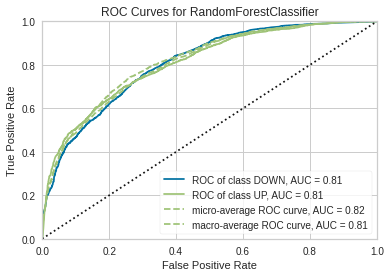

In [41]:
plot_model(tuned_model, plot = 'auc')

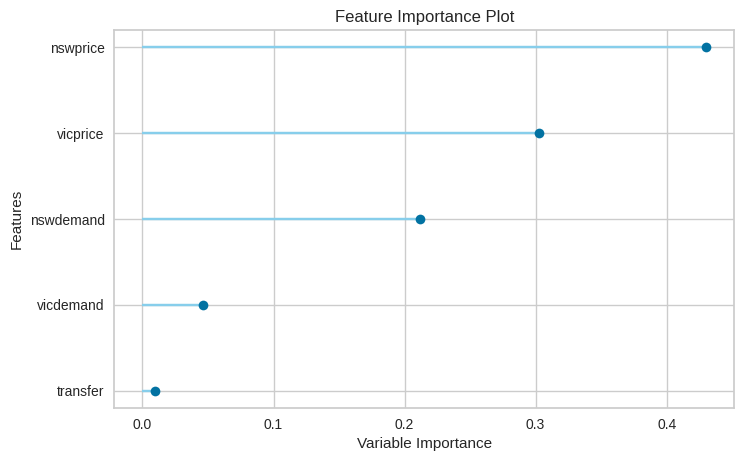

In [42]:
plot_model(tuned_model, plot='feature')

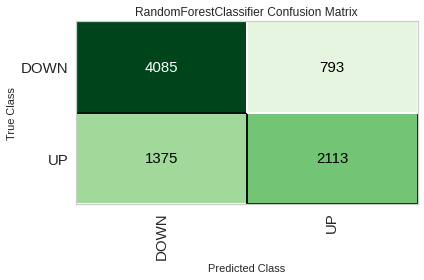

In [43]:
plot_model(tuned_model, plot = 'confusion_matrix')

In [44]:
# finalize model
final_model = finalize_model(tuned_model)

# Testing the Model

In [45]:
test

,nswprice,nswdemand,vicprice,vicdemand,transfer,target
1998-11-01 00:00:00,0.051189,0.416989,0.003452,0.390471,0.494737,DOWN
1998-11-01 00:30:00,0.053020,0.354805,0.003552,0.348783,0.521491,DOWN
1998-11-01 01:00:00,0.051519,0.300655,0.003457,0.411445,0.423246,DOWN
1998-11-01 01:30:00,0.045304,0.248140,0.003066,0.370533,0.460526,DOWN
1998-11-01 02:00:00,0.044374,0.198453,0.002973,0.311497,0.499123,DOWN
...,...,...,...,...,...,...
1998-12-06 21:30:00,0.044224,0.340672,0.003033,0.255049,0.405263,DOWN
1998-12-06 22:00:00,0.044884,0.355549,0.003072,0.241326,0.420614,DOWN
1998-12-06 22:30:00,0.043593,0.340970,0.002983,0.247799,0.362281,DOWN
1998-12-06 23:00:00,0.066651,0.329366,0.004630,0.345417,0.206579,UP


In [46]:
test_target= test['target']

In [47]:
test.drop(columns='target', inplace=True)

In [48]:
prediction = predict_model(final_model, data=test)

In [49]:
print(classification_report(prediction.Label, test_target))

              precision    recall  f1-score   support

        DOWN       0.84      0.80      0.82      1056
          UP       0.70      0.75      0.73       672

    accuracy                           0.78      1728
   macro avg       0.77      0.78      0.77      1728
weighted avg       0.78      0.78      0.78      1728



In [50]:
print(confusion_matrix(prediction.Label, test_target))

[[843 213]
 [165 507]]


In [52]:
save_model(final_model,'Final_RF_Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='target',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                         class_weight='balanced_subsample',
                                         criterion='gini', max_depth=6,
                                         max_features